# Objetivos del proyecto.

Vamos a analizar un conjunto de datos de la Universidad de Wisconsin, que contiene información sobre pacientes con posible cáncer de mama, junto con su clasificación (diagnóstico positivo o negativo).

Nuestro objetivo será entrenar y comparar diversos modelos de conjunto (ensemble models) para evaluar su desempeño.

Dado que este es un problema de diagnóstico médico, priorizaremos la métrica de recall, definida como: $$Recall=\frac{True positives}{True positives + False Negatives},$$ ya que tiene más importancia detectar todos los posibles casos de cancer aunque esto nos lleve a dar algún falso positivo. 

_Es importante notar que en la práctica clínica moderna, el sobrediagnóstico del cáncer de mama es un tema muy importante. Detectar un cáncer que nunca habría causado síntomas o problemas en la vida de la paciente puede llevar a tratamientos innecesarios. De hecho, el sobrediagnóstico es actualmente uno de los principales inconvenientes de la práctica extendida de mamografías. Para más información, véase el artículo:  https://pmc.ncbi.nlm.nih.gov/articles/PMC5365181/#:~:text=Overdiagnosis%20(overdetection)%20of%20BC%20from,side%20of%20population%20breast%20screening._

En este proyecto, no solo nos interesa la precisión del modelo con respecto a métricas estándar, sino que también es fundamental evaluar su interpretabilidad. En sectores como la salud (y en áreas financieras como la concesión de préstamos hipotecarios), es indispensable entender por qué un modelo toma ciertas decisiones. Para lograrlo, utilizaremos la técnica de **Shapley Values**, que permite explicar la contribución de cada variable en las predicciones. Además, exploraremos otras técnicas complementarias para mejorar el análisis de las decisiones del modelo.

# Paquetes

En esta sección simplemente cargaremos todos los paquetes necesarios para llevar a cabo el análisis.

In [3]:
# Load libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

# Cargando y explicando el dataset

A continuación cargamos el dataset y sus metadatos para analizarlo.

In [4]:
from ucimlrepo import fetch_ucirepo 
  

breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

print(breast_cancer_wisconsin_diagnostic.metadata) 
   
print(breast_cancer_wisconsin_diagnostic.variables) 

df = pd.concat([X, y], axis=1)
df['Diagnosis']=df['Diagnosis'].map({'M': 1, 'B': 0})

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

Puesto que los metadatos no contienen demasiada información, vamos a explicar un poco las caracterisitcas de este conjunto de datos. Los detalles que se presentan a continuación pueden encontrarse en:https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic.

# Conjunto de Datos: Breast Cancer Wisconsin (Diagnostic)

El conjunto de datos **Breast Cancer Wisconsin (Diagnostic)** contiene información derivada de imágenes digitalizadas de aspiraciones con aguja fina (**FNA**) de masas mamarias.  
Cada instancia representa características de los núcleos celulares presentes en la imagen.

## Columnas del Conjunto de Datos

### Identificación y Diagnóstico
- **ID**: Número de identificación del paciente.
- **Diagnóstico**: Clasificación del tumor, donde **"M"** indica maligno y **"B"** indica benigno.

### Características de los Núcleos Celulares
Para cada núcleo celular, se calcularon **10 características reales**:

1. **Radio**: Promedio de las distancias desde el centro hasta los puntos en el perímetro.
2. **Textura**: Desviación estándar de los valores de escala de grises.
3. **Perímetro**: Longitud del perímetro del núcleo.
4. **Área**: Área del núcleo.
5. **Suavidad**: Variación local en las longitudes del radio.
6. **Compacidad**: $ \text{Perímetro}^2 / \text{Área} - 1.0 .$
7. **Concavidad**: Severidad de las porciones cóncavas del contorno.
8. **Puntos cóncavos**: Número de porciones cóncavas del contorno.
9. **Simetría**: Simetría del núcleo.
10. **Dimensión fractal**: "Aproximación de la línea de costa" - 1.

### Valores Calculados para Cada Característica
Para cada una de estas 10 características, se calcularon **tres valores**:

- **Media**: Valor promedio de la característica.  
- **Error estándar**: Desviación estándar de la característica.  
- **Peor valor**: Mayor valor observado (promedio de los tres valores más grandes).  

Esto da lugar a un total de **30 columnas de características** en el conjunto de datos.

### Ejemplo de Columnas en el Dataset

| Tipo | Radio | Textura | Perímetro |
|------|-------|---------|-----------|
| **Media** | `radius_mean` | `texture_mean` | `perimeter_mean` |
| **Error estándar** | `radius_se` | `texture_se` | `perimeter_se` |
| **Peor valor** | `radius_worst` | `texture_worst` | `perimeter_worst` |

Y así sucesivamente para las demás características.

Puesto que queda mucho más claro tener los nombres con _mean _se y _worst en lugar de 1 2 y 3, los sustituimos a continuación.


In [5]:
df.columns = df.columns.str.replace('1', '_mean').str.replace('2', '_se').str.replace('3', '_worst')
print(df.shape)
df.head()


(569, 31)


radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean  ...  texture_worst  perimeter_worst  area_worst  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave_points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  Diagnosis  
0          0.4601                  0.11890          1  
1          0.2750                  0.08902          1  
2          0.3613                  0.08758          1  
3          0.6638                  0.17300          1  
4          0.2364                  0.07678          1  

[5 rows x 31 columns]

Vamos también a guardar los subconjuntos de columnas en variables para usarlas durante el resto del proyecto.

In [6]:
mean_columns = [col for col in df.columns if col.endswith('_mean')]
se_columns = [col for col in df.columns if col.endswith('_se')]
worst_columns = [col for col in df.columns if col.endswith('_worst')]
features=mean_columns+se_columns+worst_columns

target='Diagnosis'

# Fase preprocesado

## Estadistica basica

In [7]:
pd.set_option('display.precision', 3)
df.describe()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
count      569.000       569.000         569.000    569.000          569.000   
mean        14.127        19.290          91.969    654.889            0.096   
std          3.524         4.301          24.299    351.914            0.014   
min          6.981         9.710          43.790    143.500            0.053   
25%         11.700        16.170          75.170    420.300            0.086   
50%         13.370        18.840          86.240    551.100            0.096   
75%         15.780        21.800         104.100    782.700            0.105   
max         28.110        39.280         188.500   2501.000            0.163   

       compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
count           569.000         569.000              569.000        569.000   
mean              0.104           0.089                0.049          0.181   
std               0.053           0.080                0.039          0.027   
min               0.019           0.000                0.000          0.106   
25%               0.065           0.030                0.020          0.162   
50%               0.093           0.062                0.034          0.179   
75%               0.130           0.131                0.074          0.196   
max               0.345           0.427                0.201          0.304   

       fractal_dimension_mean  ...  texture_worst  perimeter_worst  \
count                 569.000  ...        569.000          569.000   
mean                    0.063  ...         25.677          107.261   
std                     0.007  ...          6.146           33.603   
min                     0.050  ...         12.020           50.410   
25%                     0.058  ...         21.080           84.110   
50%                     0.062  ...         25.410           97.660   
75%                     0.066  ...         29.720          125.400   
max                     0.097  ...         49.540          251.200   

       area_worst  smoothness_worst  compactness_worst  concavity_worst  \
count     569.000           569.000            569.000          569.000   
mean      880.583             0.132              0.254            0.272   
std       569.357             0.023              0.157            0.209   
min       185.200             0.071              0.027            0.000   
25%       515.300             0.117              0.147            0.115   
50%       686.500             0.131              0.212            0.227   
75%      1084.000             0.146              0.339            0.383   
max      4254.000             0.223              1.058            1.252   

       concave_points_worst  symmetry_worst  fractal_dimension_worst  \
count               569.000         569.000                  569.000   
mean                  0.115           0.290                    0.084   
std                   0.066           0.062                    0.018   
min                   0.000           0.157                    0.055   
25%                   0.065           0.250                    0.071   
50%                   0.100           0.282                    0.080   
75%                   0.161           0.318                    0.092   
max                   0.291           0.664                    0.207   

       Diagnosis  
count    569.000  
mean       0.373  
std        0.484  
min        0.000  
25%        0.000  
50%        0.000  
75%        1.000  
max        1.000  

[8 rows x 31 columns]

In [8]:
# class distribution
df.groupby('Diagnosis').size()

Diagnosis
0    357
1    212
dtype: int64

### train test split

Vamos a dividir nuestro conjunto de datos en entrenamiento y test antes de la visualización y análisis exploratorio. Aunque podríamos hacerlo después, he decidido hacerlo en este punto porque utilizaré las visualizaciones y el análisis de correlaciones para una selección preliminar de variables. Al hacerlo antes, evitamos el data leakage, es decir, la contaminación del conjunto de entrenamiento con información del test, lo que garantizará que cualquier insight obtenido provenga únicamente de los datos con los que entrenaremos el modelo.

Dado que, según la descripción de los datos, es probable que existan altas correlaciones entre muchas variables, este análisis debe realizarse con el apoyo de un experto en el dominio (en este caso, un oncólogo especializado en cáncer de mama). La razón es que, aunque algunas características estén altamente correlacionadas, pueden capturar matices clínicos distintos que queramos preservar. Además, en ciertos casos, conservar variables redundantes puede ser útil para mejorar la robustez del modelo frente a la pérdida de datos. Un ejemplo clásico es la medición de la presión arterial: si tenemos la presión arterial sistólica (PAS), la diastólica (PAD) y la presión de pulso (PAS - PAD), eliminar una de ellas por alta correlación podría hacer que el modelo sea menos resiliente si alguna medición estuviera ausente o fuera errónea.

Si bien la presencia de correlaciones no afecta el poder predictivo de los modelos que utilizaremos, sí influye en su interpretabilidad. En particular, en algoritmos como los bosques aleatorios, la importancia de las variables (feature importance) puede verse distorsionada, ya que el modelo tiende a seleccionar aleatoriamente una de entre varias características altamente correlacionadas, subestimando la relevancia real de estas variables.

Por todas estas razones, optamos por realizar la división antes del análisis exploratorio. Esto nos permitirá trabajar con una muestra representativa del conjunto de entrenamiento y garantizar que cualquier selección de variables o transformación realizada se base exclusivamente en los datos disponibles para el entrenamiento del modelo, evitando sesgos y fugas de información.

In [9]:
X_train, X_test, y_train, y_test= train_test_split(df[features],df[target],test_size=0.2)

In [10]:
scaler= StandardScaler()

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


X_train_scaled = pd.DataFrame(scaler.fit_transform(df_train[features]), columns=features, index=df_train.index)  

# Reconstruct scaled df_train
df_train_scaled = pd.concat([X_train_scaled, y_train], axis=1)

print(X_train_scaled.shape, y_train.shape)

(455, 30) (455,)


## Visualización

In [11]:
def violin_plotter(df: pd.DataFrame, features: list, split_column : str =None, palette : dict =None, ax=None) -> None:
    """
    Creates violin plots for the given features, standardized, optionally grouped by a categorical column.
    Supports subplotting for side-by-side comparisons.

    Parameters:
    - df (DataFrame): The dataset containing numerical features.
    - features (list): List of feature names to plot.
    - split_column (str, optional): Column used to split the violin plots. If None, plots without classes.
    - palette (dict, optional): Dictionary defining colors for categories in the split_column.
    - ax (matplotlib.axes._subplots.AxesSubplot, optional): Matplotlib subplot axis for side-by-side plotting.

    Returns:
    - None (Displays the violin plot inside the given subplot).
    """

    df = df.copy()  # Avoid modifying the original dataset

    # Standardize the features
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df_scaled[features])

    # Reshape data for Seaborn (Melt the dataframe)
    if split_column and split_column in df.columns:
        df_scaled[split_column] = df_scaled[split_column].astype('category')  # Ensure categorical type
        df_melted = df_scaled.melt(id_vars=[split_column], value_vars=features, 
                                   var_name="Feature", value_name="Standardized Value")
    else:
        df_melted = df_scaled.melt(value_vars=features, var_name="Feature", value_name="Standardized Value")
        split_column = None  # Ensure it's set to None for plotting

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6)) 

    # Create the violin plot
    if split_column:
        sns.violinplot(x="Feature", y="Standardized Value", hue=split_column, data=df_melted, 
                       split=True, inner="quartile", palette=palette, ax=ax)
        ax.legend(title=split_column)
    else:
        sns.violinplot(x="Feature", y="Standardized Value", data=df_melted, inner="quartile", color="skyblue", ax=ax)

    # Improve aesthetics
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title("Standardized Distribution of Features" + (f" by {split_column}" if split_column else ""))
    return None


def swarm_plotter(df: pd.DataFrame, features: list, split_column : str =None, ax=None, palette : dict =None) -> None:
    """
    Creates swarm plots for the given features, standardized, optionally grouped by a categorical column.
    Supports subplotting for side-by-side comparisons.

    Parameters:
    - df (DataFrame): The dataset containing numerical features.
    - features (list): List of feature names to plot.
    - split_column (str, optional): Column used to split the violin plots. If None, plots without classes.
    - palette (dict, optional): Dictionary defining colors for categories in the split_column.
    - ax (matplotlib.axes._subplots.AxesSubplot, optional): Matplotlib subplot axis for side-by-side plotting.

    Returns:
    - None (Displays the violin plot inside the given subplot).
    """

    df = df.copy()  # Avoid modifying the original dataset

    # Standardize the features
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df_scaled[features])

    # Reshape data for Seaborn (Melt the dataframe)
    if split_column and split_column in df.columns:
        df_scaled[split_column] = df_scaled[split_column].astype('category')  # Ensure categorical type
        df_melted = df_scaled.melt(id_vars=[split_column], value_vars=features, 
                                   var_name="Feature", value_name="Standardized Value")
    else:
        df_melted = df_scaled.melt(value_vars=features, var_name="Feature", value_name="Standardized Value")
        split_column = None  # Ensure it's set to None for plotting

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6)) 

    # Create the violin plot
    if split_column:
        sns.swarmplot(x="Feature", y="Standardized Value", hue=split_column, data=df_melted, ax=ax, palette=palette)
        ax.legend(title=split_column)

        #sns.swarmplot(x="Feature", y="Standardized Value", hue=split_column, data=df_melted, 
        #               split=True, palette=palette, ax=ax)
        #ax.legend(title=split_column)
    else:
        sns.swarmplot(x="Feature", y="Standardized Value", data=df_melted, color="skyblue", ax=ax, palette=palette)

    # Improve aesthetics
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title("Standardized Distribution of Features" + (f" by {split_column}" if split_column else ""))
    return None


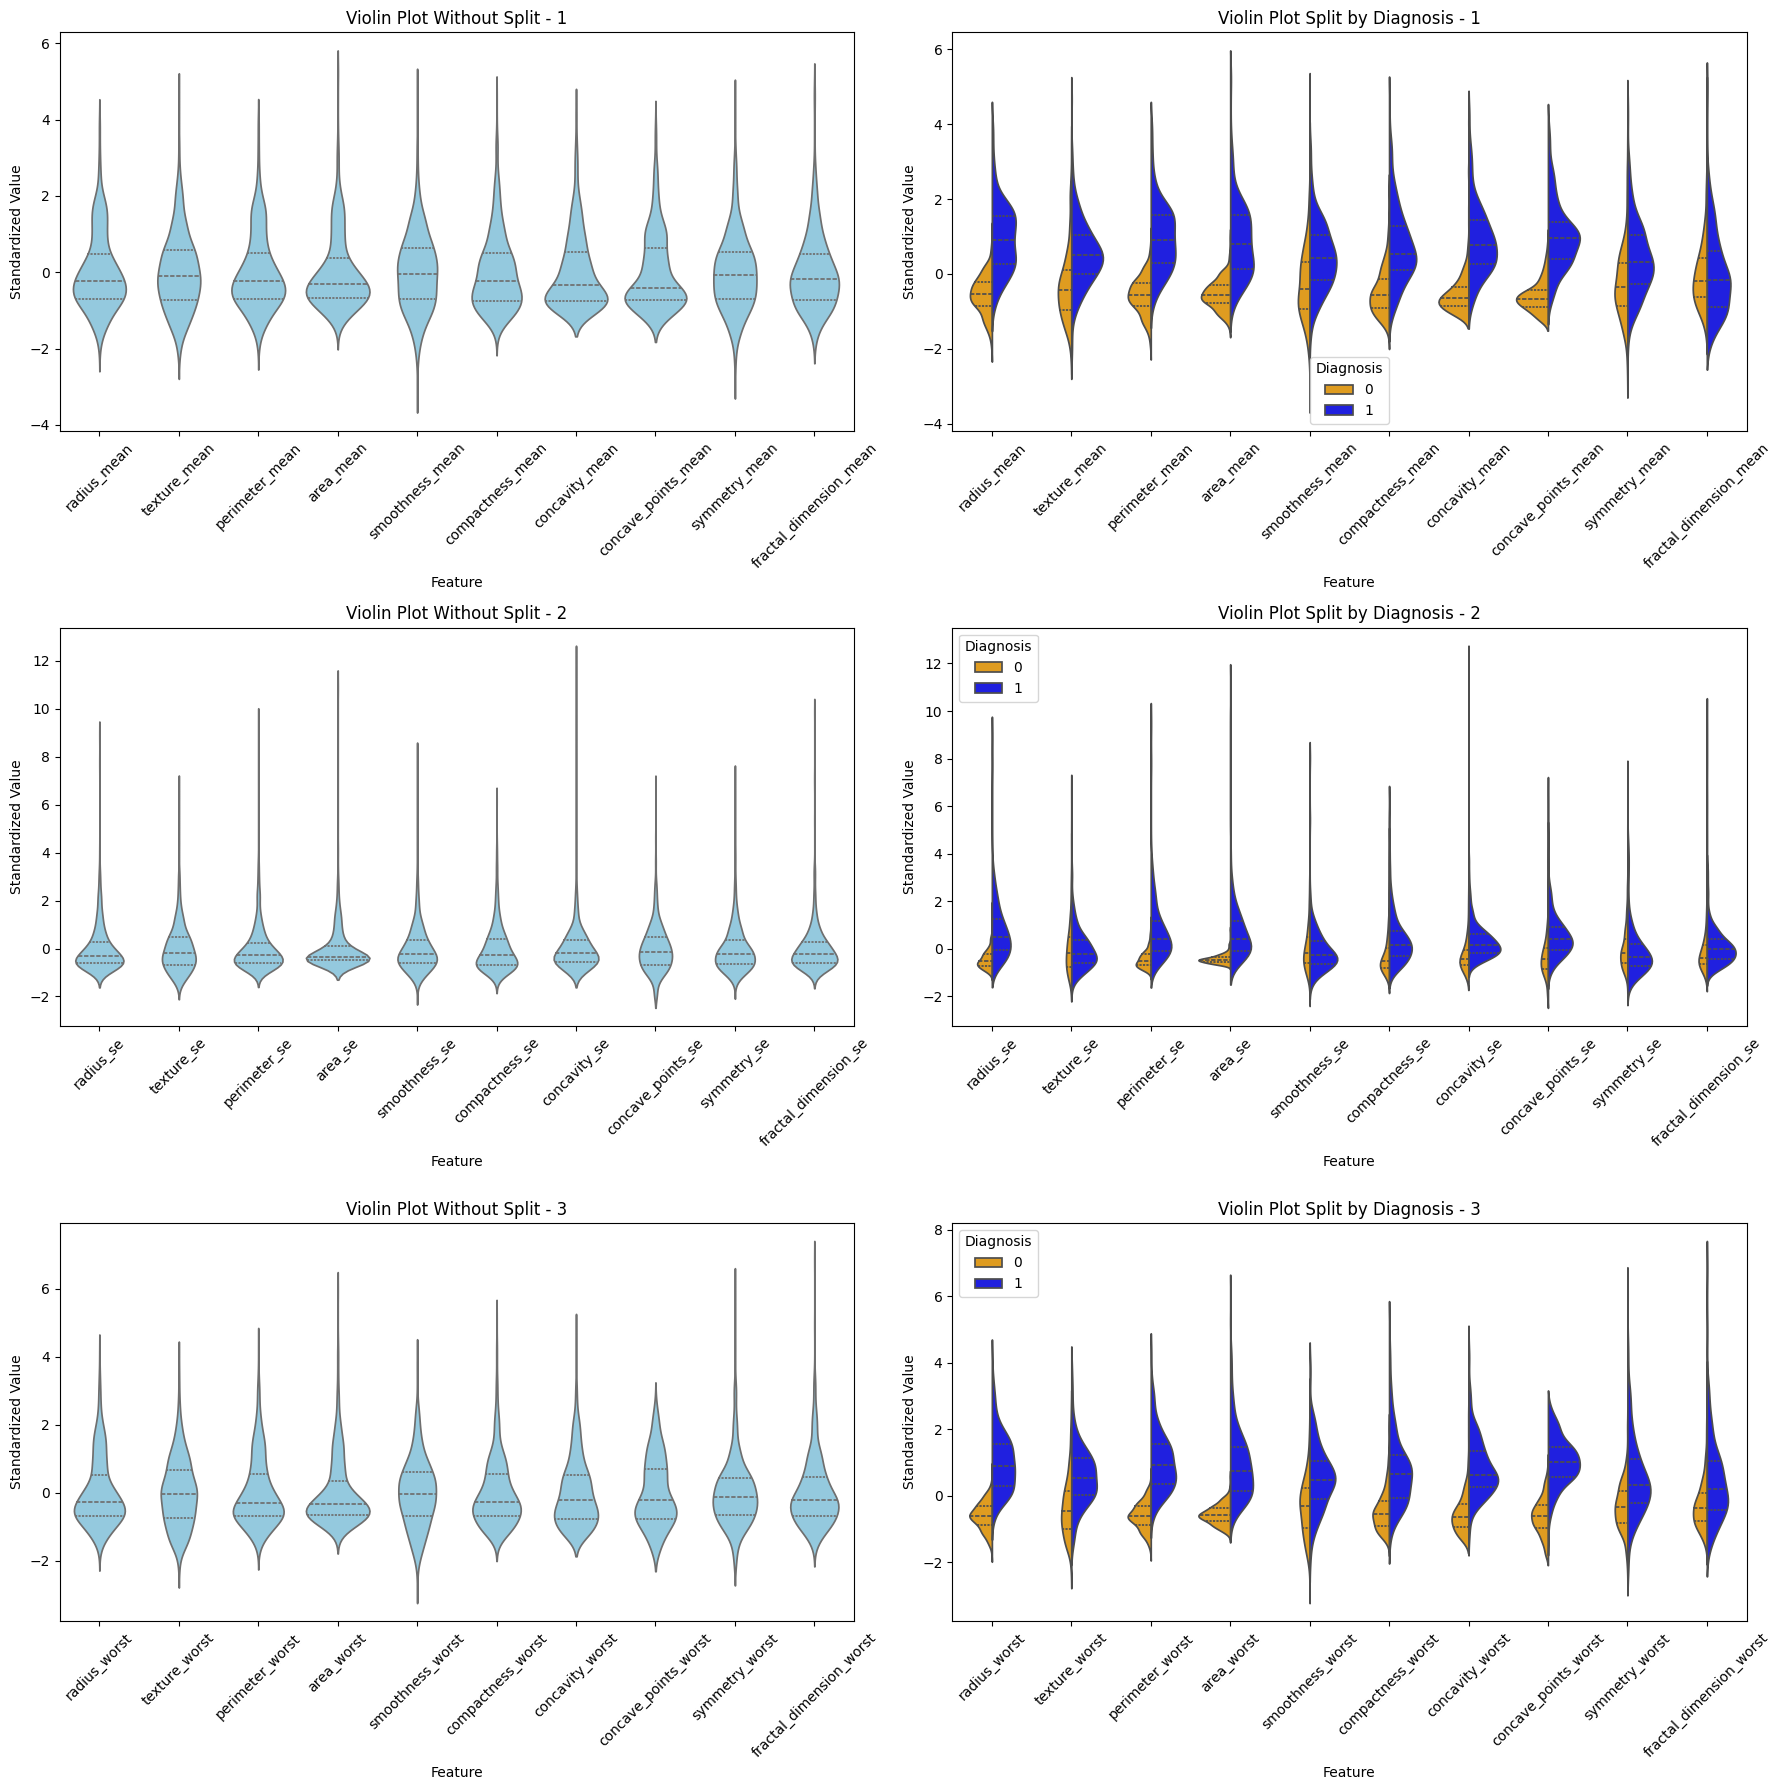

In [12]:
palette = {1: "blue", 0: "orange"}

fig, axes = plt.subplots(3, 2, figsize=(18, 18)) 

# List of feature sets for each row (customize as needed)
feature_groups = [
    mean_columns,  # Row 1, Left: Mean Features
    se_columns,    # Row 2, Left: SE Features
    worst_columns  # Row 3, Left: Worst Features
]

for i, ax_row in enumerate(axes):

    violin_plotter(df, feature_groups[i], ax=ax_row[0])
    ax_row[0].set_title(f"Violin Plot Without Split - {i+1}")

    violin_plotter(df, feature_groups[i], split_column="Diagnosis", palette=palette, ax=ax_row[1])
    ax_row[1].set_title(f"Violin Plot Split by Diagnosis - {i+1}")


plt.tight_layout()
plt.show()


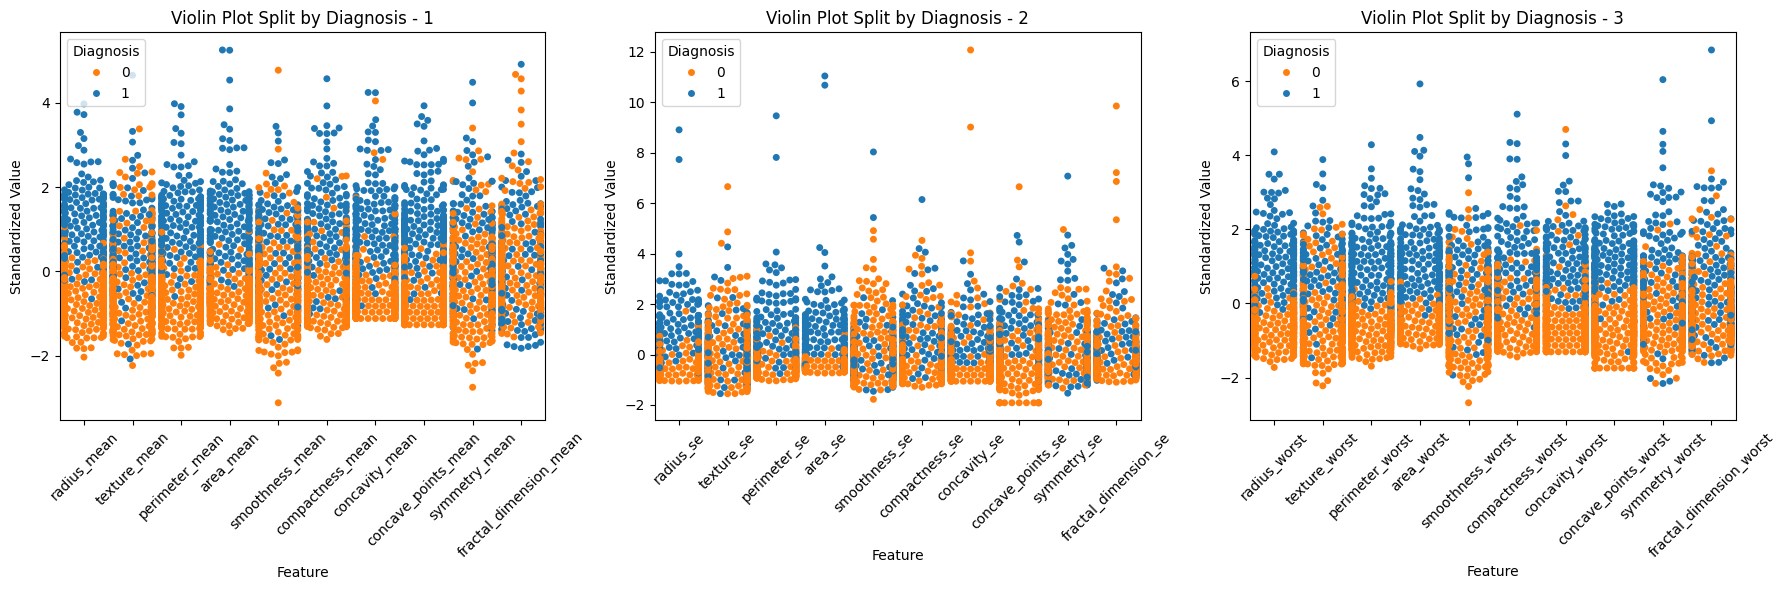

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Ajusté la altura también

feature_groups = [
    mean_columns,
    se_columns,
    worst_columns
]

for i, ax in enumerate(axes):
    swarm_plotter(df, feature_groups[i], split_column="Diagnosis", ax=ax, palette={1: "#1f77b4", 0: "#ff7f0e"} )
    ax.set_title(f"Violin Plot Split by Diagnosis - {i+1}")

plt.tight_layout()
plt.show()


## Correlaciones

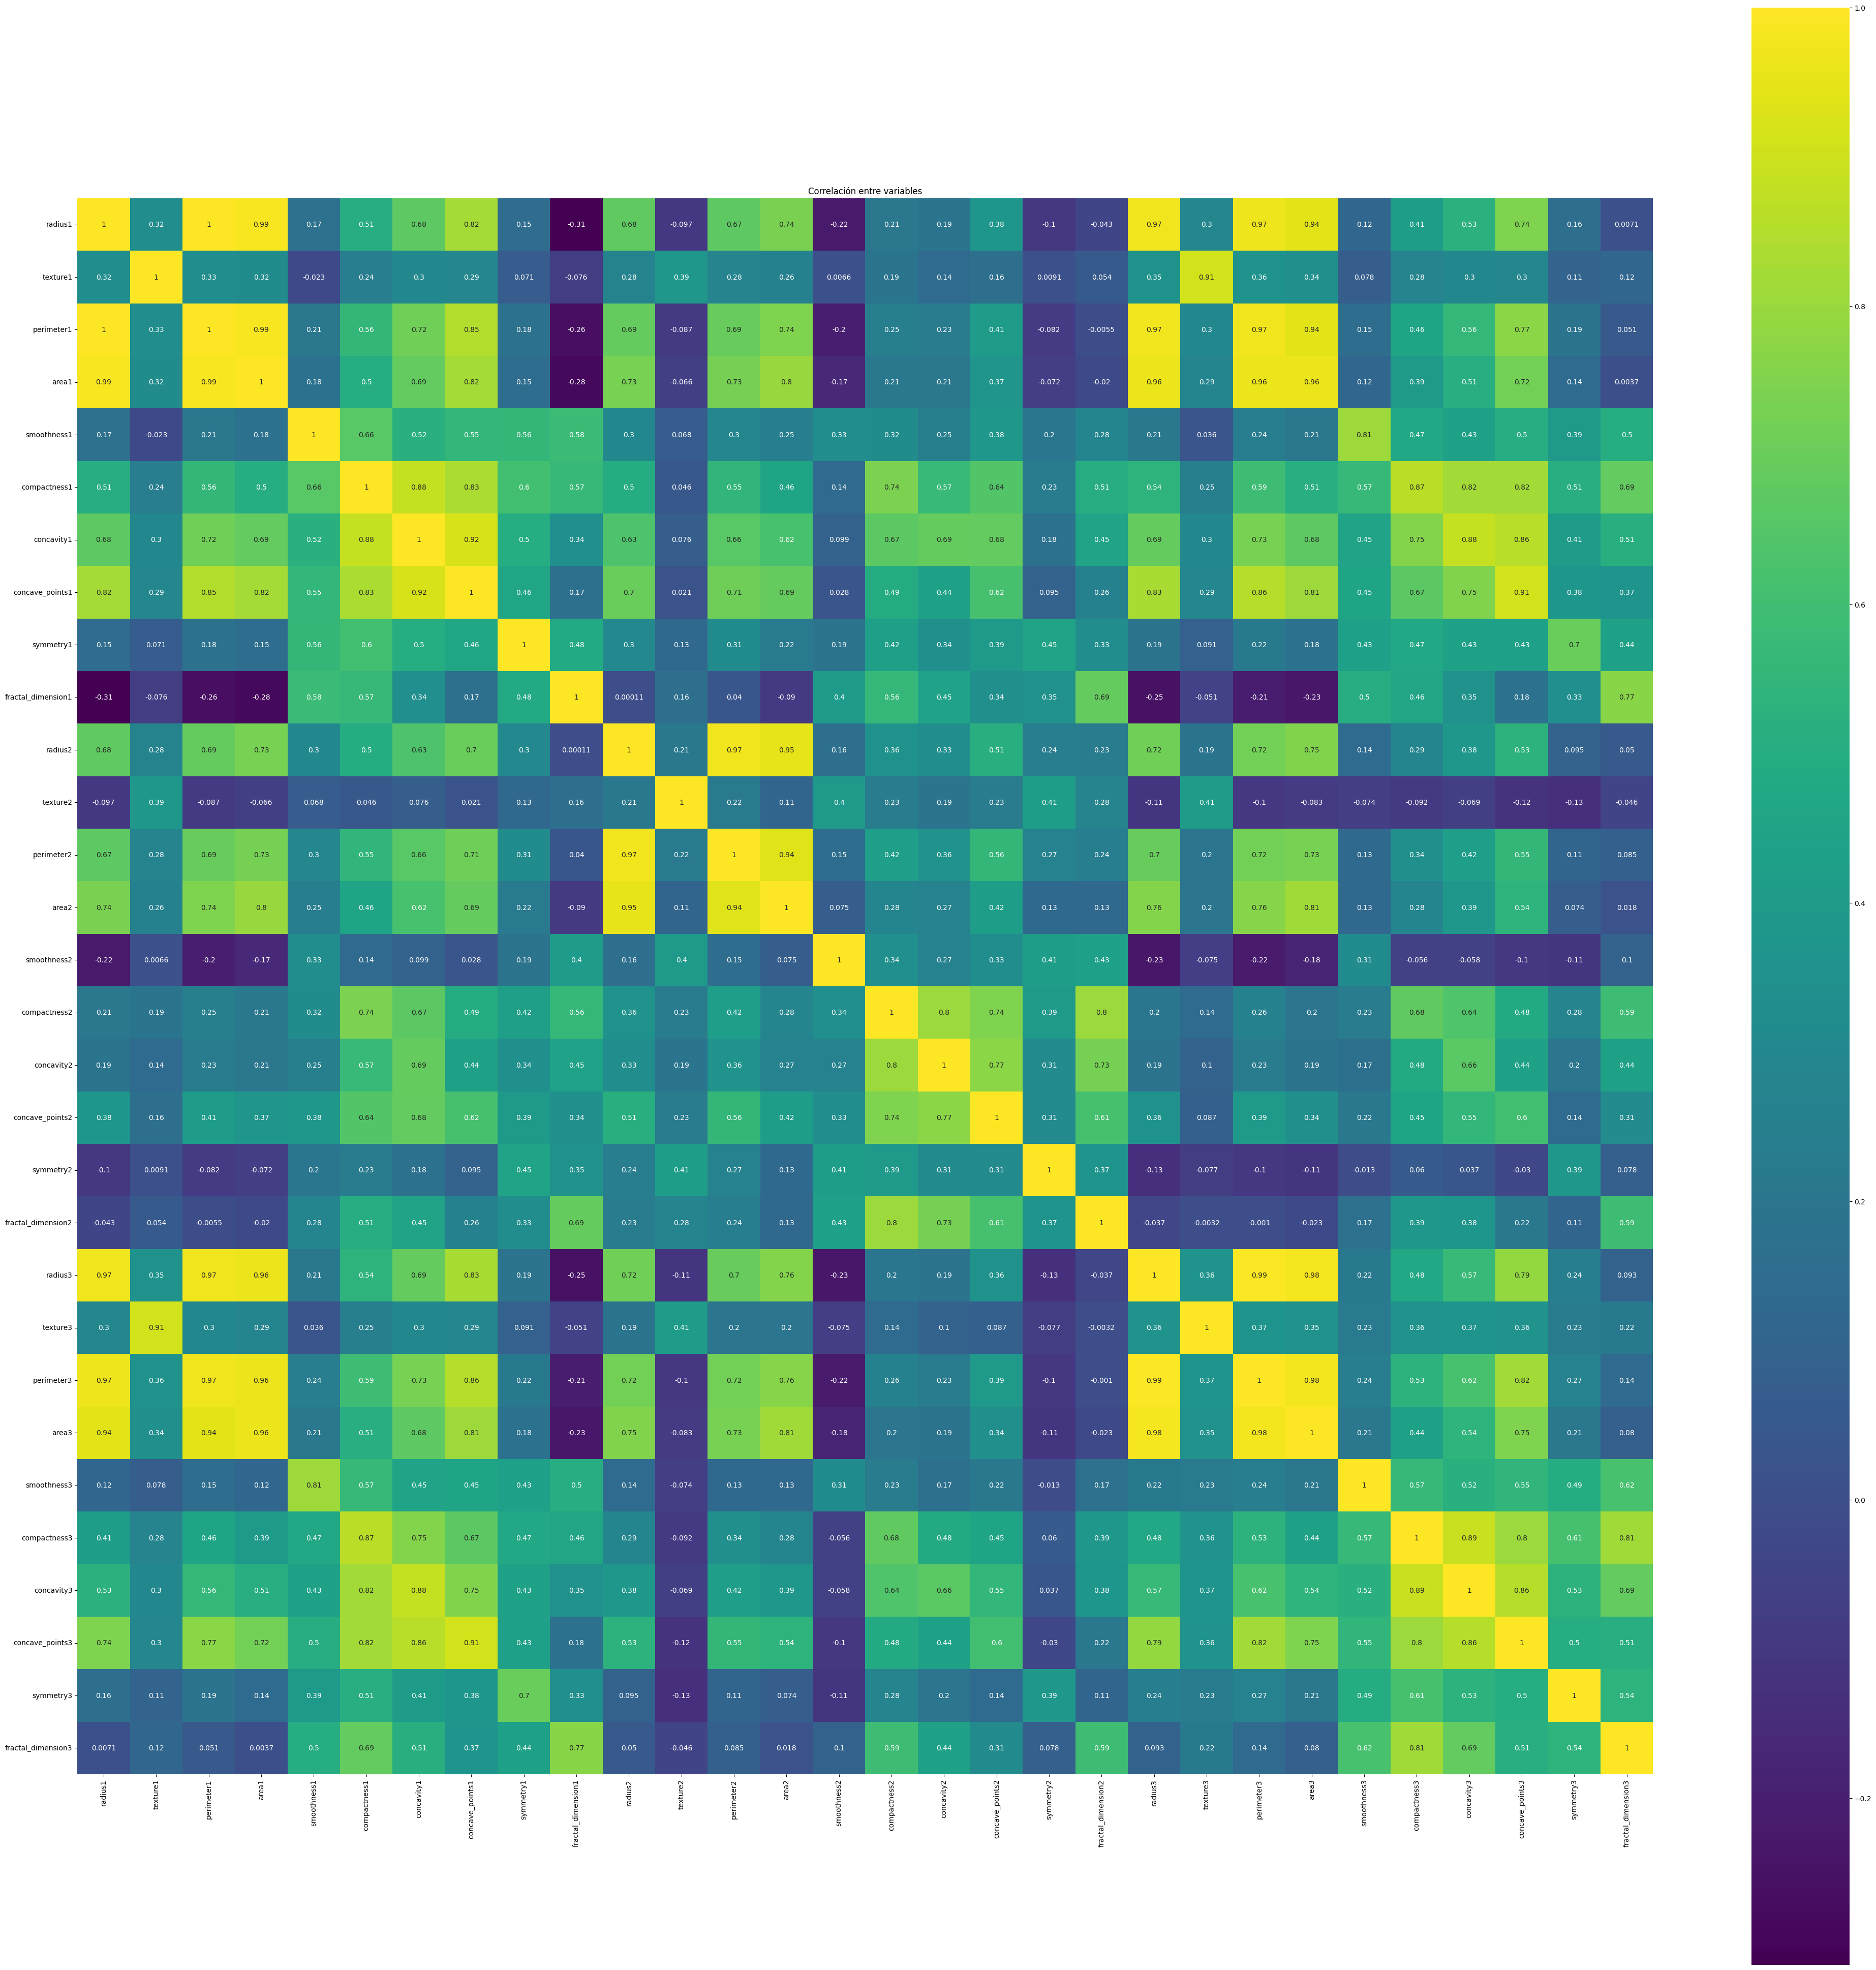

In [14]:
correlation = X.corr()
plt.figure(figsize=(50,50))
ax = sns.heatmap(correlation, vmax=1, square=True, annot = True, cmap = 'viridis')
# Esto se ponde debido al bug de Matplotlib 3.1.1 (quitarlo en versiones diferentes)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
# ----------
plt.title('Correlación entre variables')
plt.show()

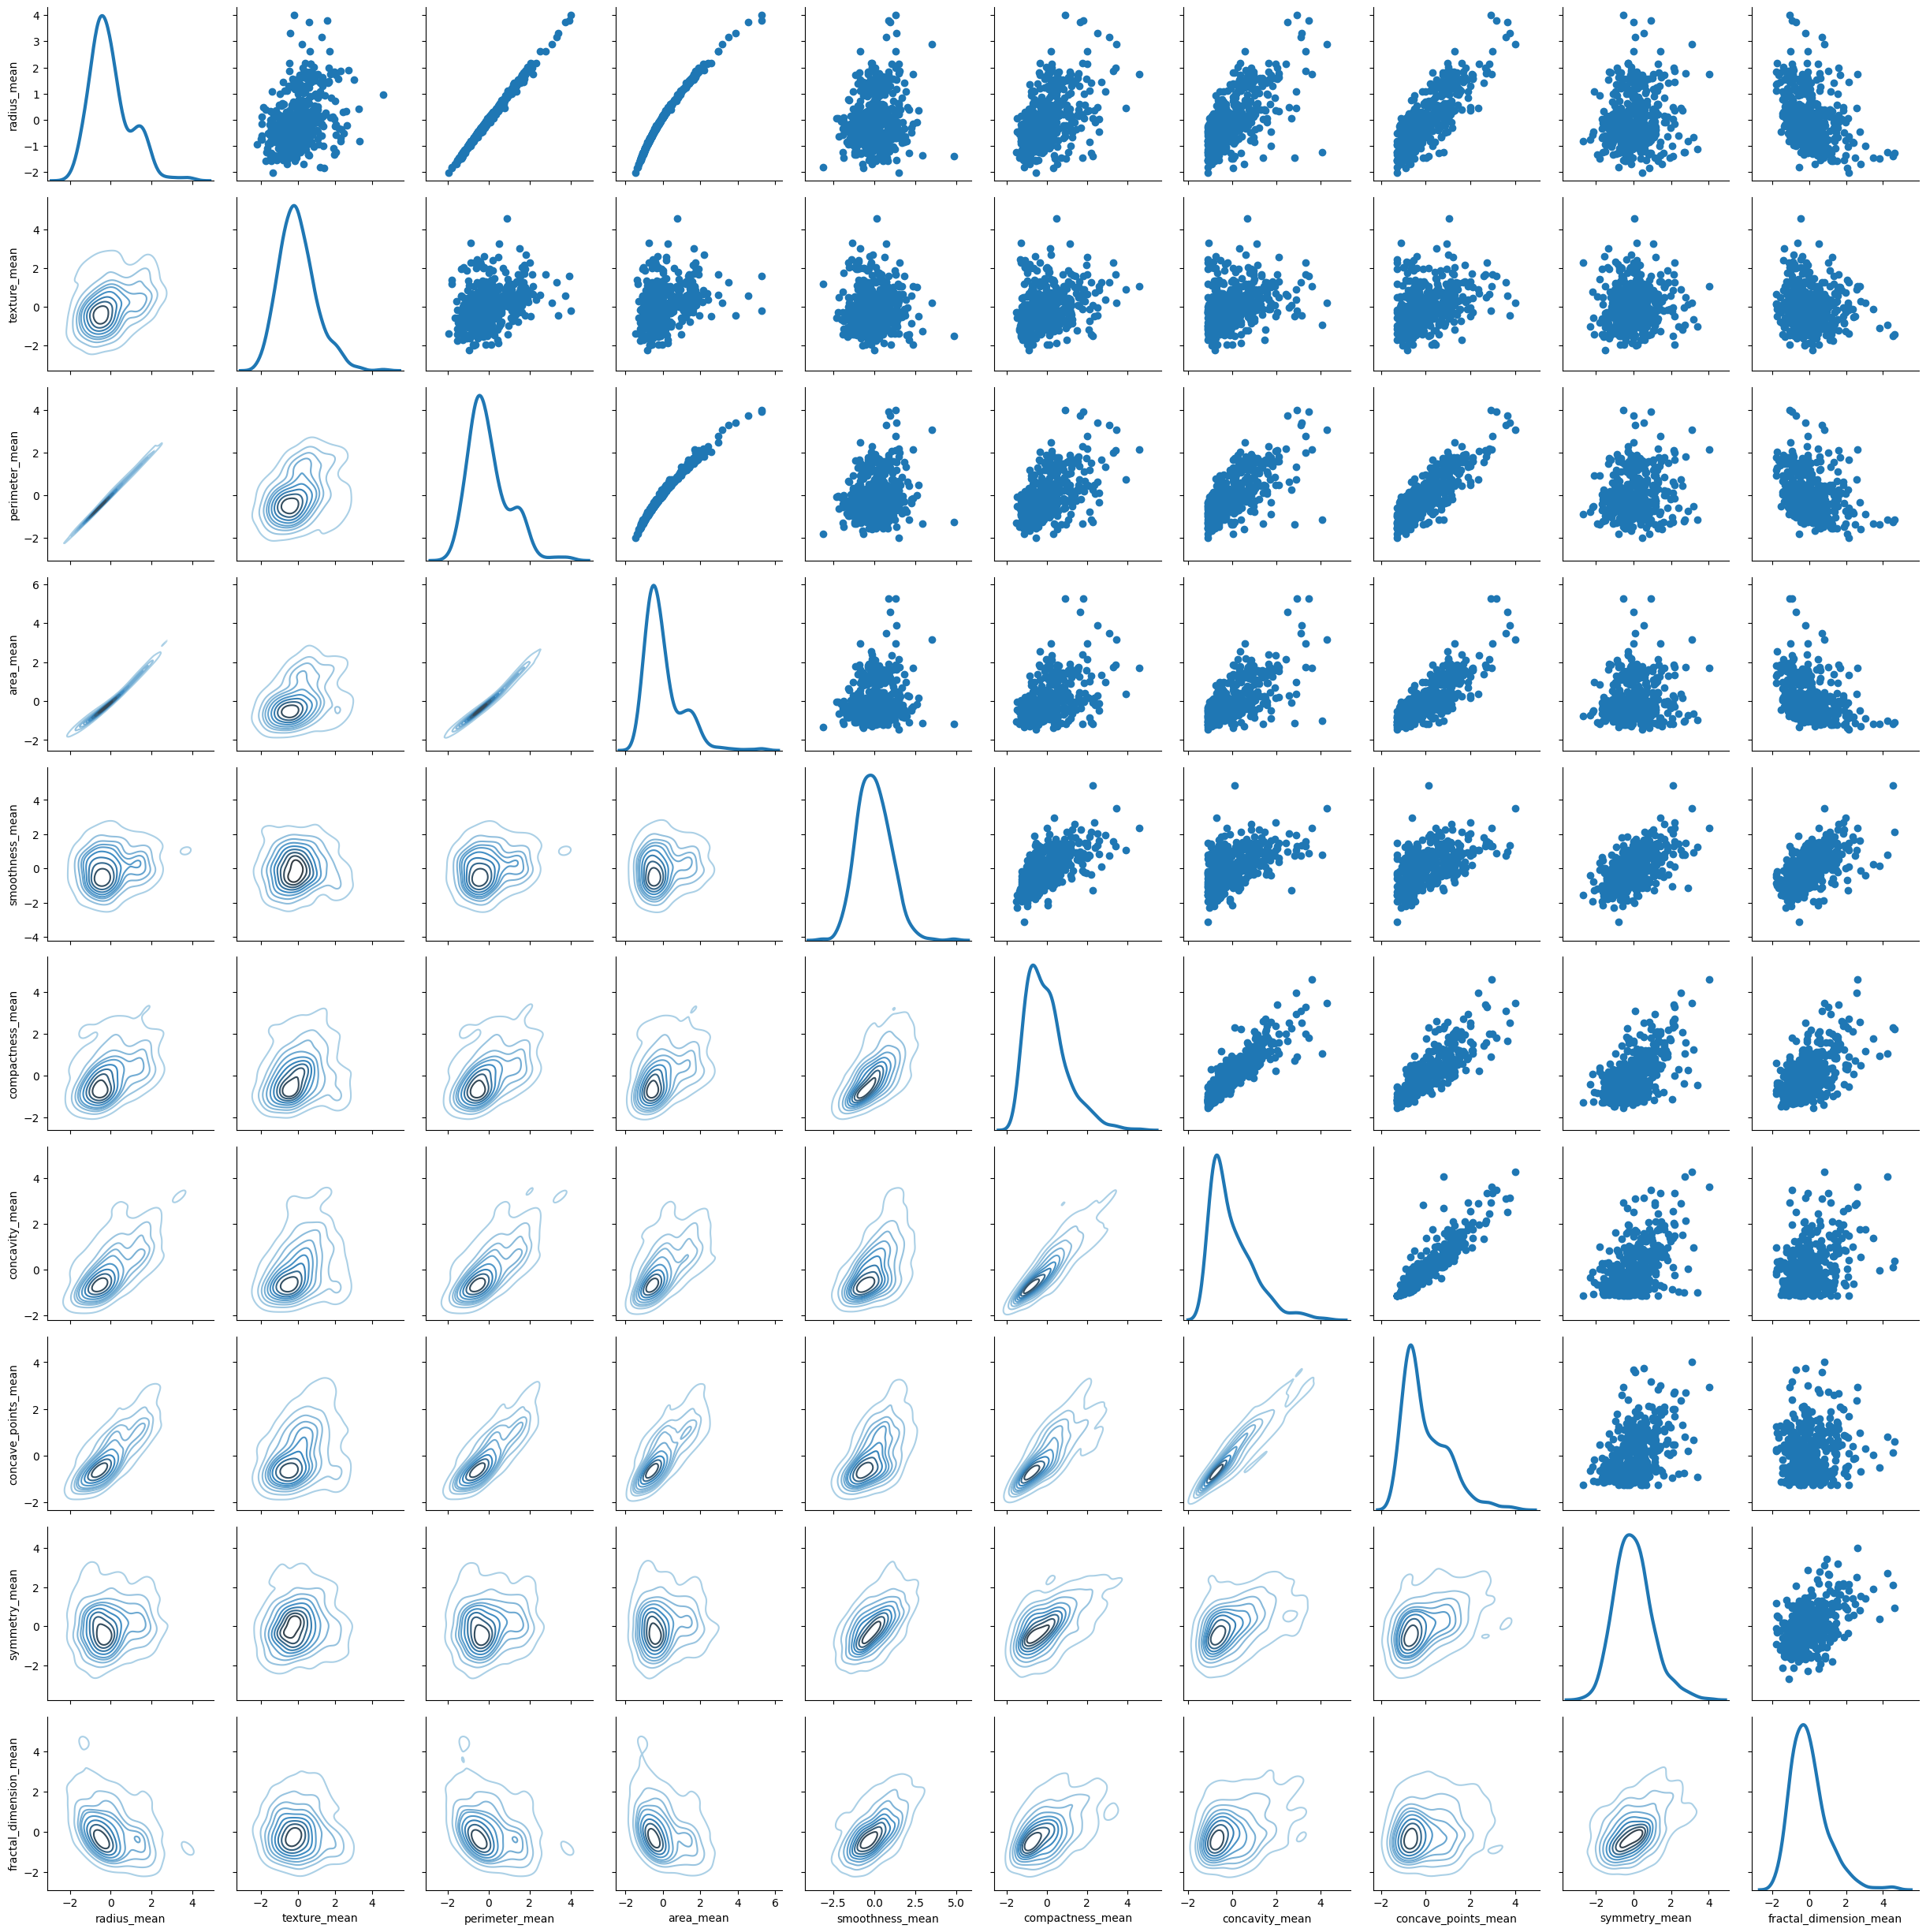

In [15]:
g = sns.PairGrid(df_train_scaled[mean_columns], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

## Feature importance

In [16]:
rnf=RandomForestClassifier(500,n_jobs=-1)
rnf.fit(X_train_scaled,y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

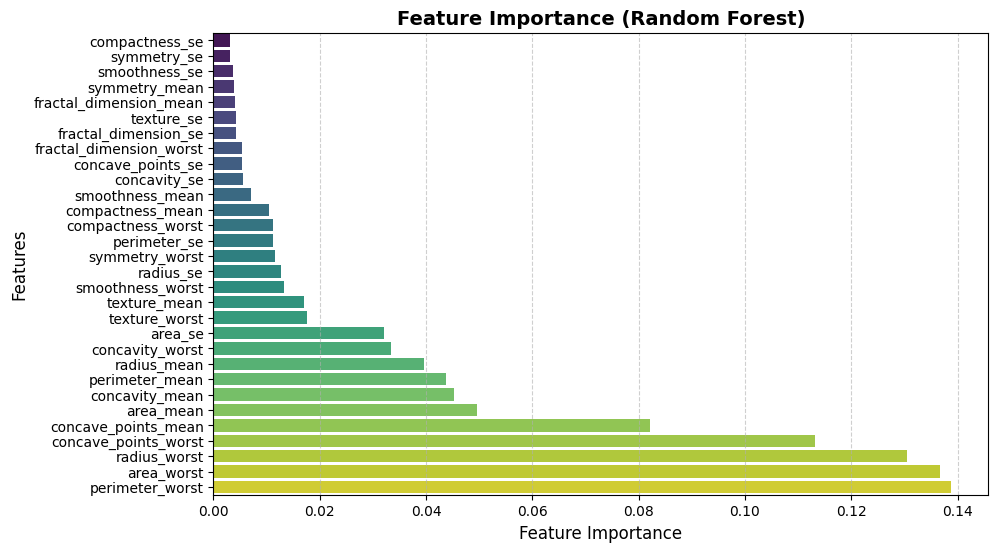

In [17]:
feat_importances = pd.Series(rnf.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances.values, y=feat_importances.index, palette="viridis")
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance (Random Forest)", fontsize=14, fontweight="bold")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

In [18]:
num_runs = 50

# Store feature importances for each run
feature_importances = np.zeros((num_runs, X_train_scaled.shape[1]))

# Run Random Forest multiple times
for i in range(num_runs):
    rnf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
    rnf.fit(X_train_scaled, y_train)
    feature_importances[i, :] = rnf.feature_importances_

# Compute the average and standard deviation of feature importance
avg_importances = feature_importances.mean(axis=0)
std_importances = feature_importances.std(axis=0)

# Convert to Pandas Series for visualization
#feat_importances = pd.Series(avg_importances, index=X_train.columns).sort_values(ascending=True)
feat_importances = pd.Series(avg_importances, index=X_train_scaled.columns).sort_values(ascending=True)
std_sorted = pd.Series(std_importances, index=X_train_scaled.columns).loc[feat_importances.index]

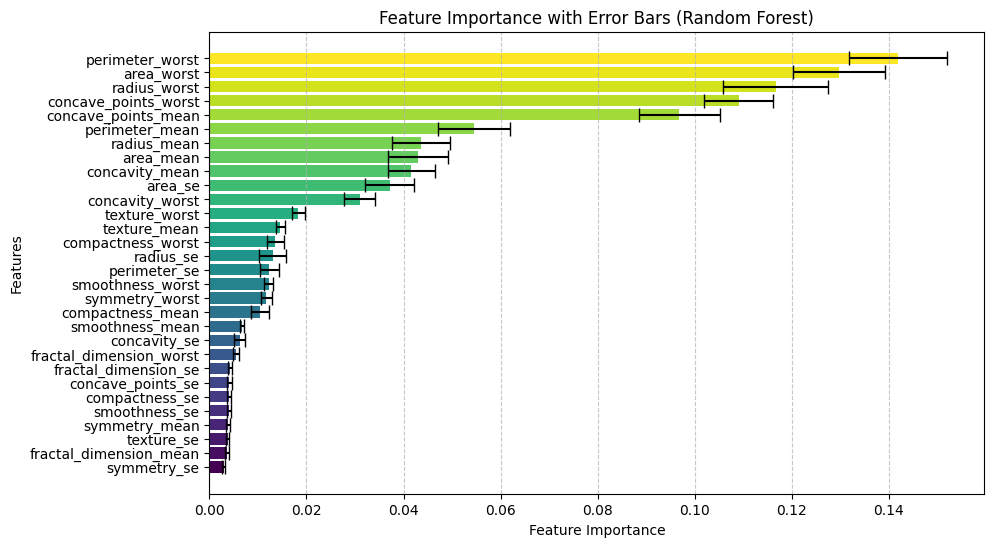

In [19]:
feature_importance_df = pd.DataFrame({
    'Feature': feat_importances.index,
    'Importance': feat_importances.values,
    'Std Dev': std_sorted.values}) 

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], 
        feature_importance_df['Importance'], 
        xerr=feature_importance_df['Std Dev'], 
        capsize=5, color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df))))
    
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance with Error Bars (Random Forest)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [20]:
important_columns=feature_importance_df.nlargest(11, 'Importance')['Feature'].to_list()

In [21]:
X_filtered=X_train_scaled[important_columns]
X_filtered

perimeter_worst  area_worst  radius_worst  concave_points_worst  \
263            0.273       0.200         0.351                -0.428   
342           -0.819      -0.774        -0.899                -0.090   
408            0.944       0.840         1.013                 1.302   
57             0.267       0.195         0.343                 1.085   
385           -0.141      -0.209        -0.091                 0.349   
..               ...         ...           ...                   ...   
146           -0.451      -0.505        -0.519                 1.133   
533            1.364       1.365         1.462                 0.743   
279           -0.257      -0.366        -0.260                -0.207   
376           -0.917      -0.930        -1.122                 0.514   
277            0.669       0.639         0.779                 0.249   

     concave_points_mean  perimeter_mean  radius_mean  area_mean  \
263               -0.519           0.340        0.430      0.303   
342               -0.389          -0.840       -0.868     -0.796   
408                1.049           1.077        1.108      0.969   
57                 0.865           0.156        0.173      0.012   
385                0.117           0.091        0.142      0.035   
..                   ...             ...          ...        ...   
146                0.680          -0.529       -0.657     -0.630   
533                1.397           1.776        1.816      1.848   
279               -0.292          -0.116       -0.072     -0.186   
376                0.293          -0.895       -1.007     -0.898   
277                0.267           1.205        1.342      1.285   

     concavity_mean  area_se  concavity_worst  
263          -0.588   -0.379           -0.224  
342          -0.438   -0.622           -0.206  
408           0.399    0.210            0.276  
57            0.516    0.003            0.414  
385          -0.059   -0.148           -0.025  
..              ...      ...              ...  
146           0.979   -0.325            0.855  
533           0.807    1.290            0.176  
279          -0.554   -0.438           -0.611  
376           1.765   -0.698            1.589  
277          -0.106   -0.068           -0.248  

[455 rows x 11 columns]

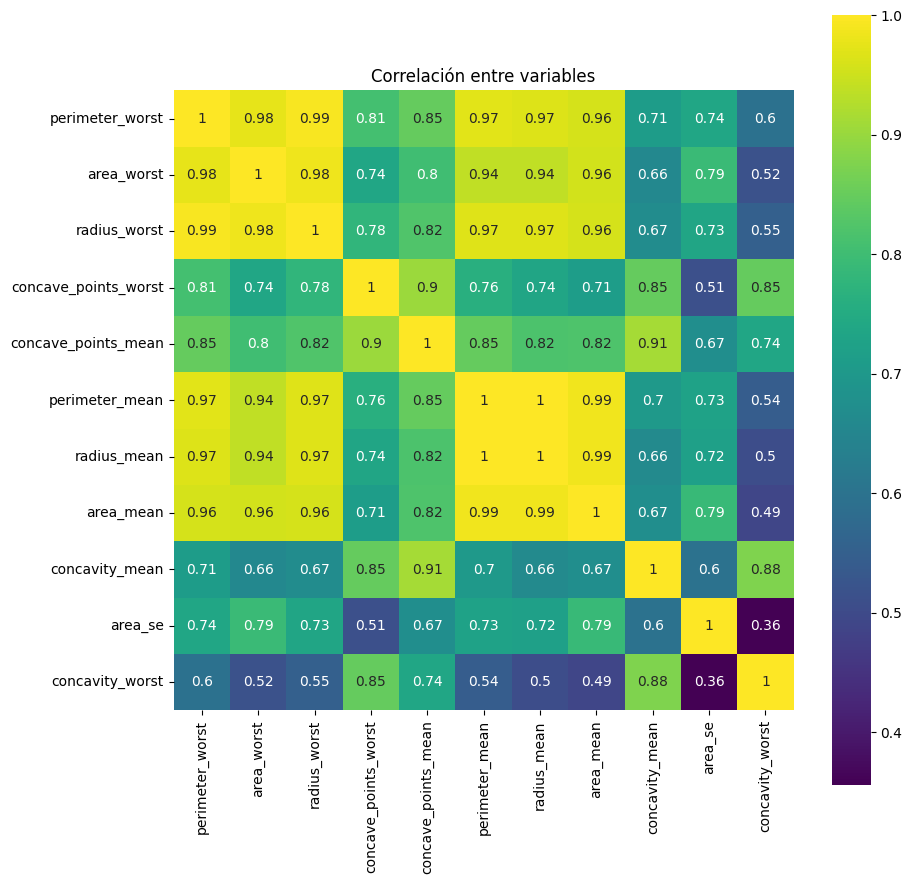

In [22]:
correlation = X_filtered.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(correlation, vmax=1, square=True, annot = True, cmap = 'viridis')
# Esto se ponde debido al bug de Matplotlib 3.1.1 (quitarlo en versiones diferentes)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
# ----------
plt.title('Correlación entre variables')
plt.show()

# Model training

In [23]:
X_train=df_train[features]
y_train=df_train[target]

In [33]:
from sklearn.naive_bayes import GaussianNB

naive_bayes_base = GaussianNB()

cv_scores = cross_val_score(naive_bayes_base, X_train, y_train, cv=5, scoring="accuracy")

print(f"AdaBoost (Naive Bayes) Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


AdaBoost (Naive Bayes) Accuracy: 0.9363 ± 0.0213


## Voting

In [48]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ],
    voting='soft'
)
cv_scores = cross_val_score(voting, X_train, y_train, cv=5, scoring="accuracy")

print(f"Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Accuracy: 0.9538 ± 0.0162


## Bagging

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

In [27]:
bagging_tree = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,  # Número de modelos en el ensamble
    random_state=42
)

cv_scores = cross_val_score(bagging_tree, X_train, y_train, cv=5, scoring="accuracy")
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Cross-Validation Accuracy Scores: [0.94505495 0.91208791 0.97802198 0.97802198 0.92307692]
Mean Accuracy: 0.9473 ± 0.0273


In [28]:
bagging_logistic = BaggingClassifier(
    estimator=LogisticRegression(max_iter=1000),
    n_estimators=50,
    random_state=42
)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(bagging_logistic, X_train, y_train, cv=5, scoring="accuracy")
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Cross-Validation Accuracy Scores: [0.95604396 0.95604396 0.95604396 0.94505495 0.95604396]
Mean Accuracy: 0.9538 ± 0.0044


## Random forest and extra trees

In [36]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="accuracy")

print(f"Random Forest Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Random Forest Accuracy: 0.9429 ± 0.0201


In [37]:
et = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

cv_scores = cross_val_score(et, X_train, y_train, cv=5, scoring="accuracy")

print(f"Extra Trees Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Extra Trees Accuracy: 0.9648 ± 0.0213


## Boosting

In [29]:
from xgboost import XGBClassifier

In [35]:
xgb_tree = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Validación cruzada
cv_scores = cross_val_score(xgb_tree, X_train, y_train, cv=5, scoring="accuracy")

print(f"XGBoost (Tree-based) Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

XGBoost (Tree-based) Accuracy: 0.9714 ± 0.0149


In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

logistic_base = LogisticRegression(max_iter=1000)

adaboost_logistic = AdaBoostClassifier(
    estimator=logistic_base,
    n_estimators=50,
    algorithm="SAMME.R",
    random_state=42
)

cv_scores = cross_val_score(adaboost_logistic, X_train, y_train, cv=5, scoring="accuracy")

print(f"AdaBoost (Logistic Regression) Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


AdaBoost (Logistic Regression) Accuracy: 0.9495 ± 0.0088


## Staking

In [38]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

stack1 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

cv_scores = cross_val_score(stack1, X_train, y_train, cv=5, scoring="accuracy")

print(f"Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Accuracy: 0.9538 ± 0.0254


In [40]:
from sklearn.linear_model import RidgeClassifier

stack2 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('logreg', LogisticRegression(max_iter=1000)),
        ('et', ExtraTreesClassifier(n_estimators=100, random_state=42))
    ],
    final_estimator=RidgeClassifier(),
    cv=5
)

cv_scores = cross_val_score(stack2, X_train, y_train, cv=5, scoring="accuracy")

print(f"Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Accuracy: 0.9604 ± 0.0112


In [44]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

stack3 = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('lgbm', LGBMClassifier()),
        ('cat', CatBoostClassifier(verbose=0))
    ],
    final_estimator=LogisticRegression(),
    cv=5
)
cv_scores = cross_val_score(stack3, X_train, y_train, cv=5, scoring="accuracy")

print(f"Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

[LightGBM] [Info] Number of positive: 134, number of negative: 230
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3642
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368132 -> initscore=-0.540240
[LightGBM] [Info] Start training from score -0.540240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [41]:
stack4 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('ada', AdaBoostClassifier()),
        ('gb', GradientBoostingClassifier())
    ],
    final_estimator=LogisticRegression(),
    cv=5
)
cv_scores = cross_val_score(stack4, X_train, y_train, cv=5, scoring="accuracy")

print(f"Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Accuracy: 0.9560 ± 0.0241


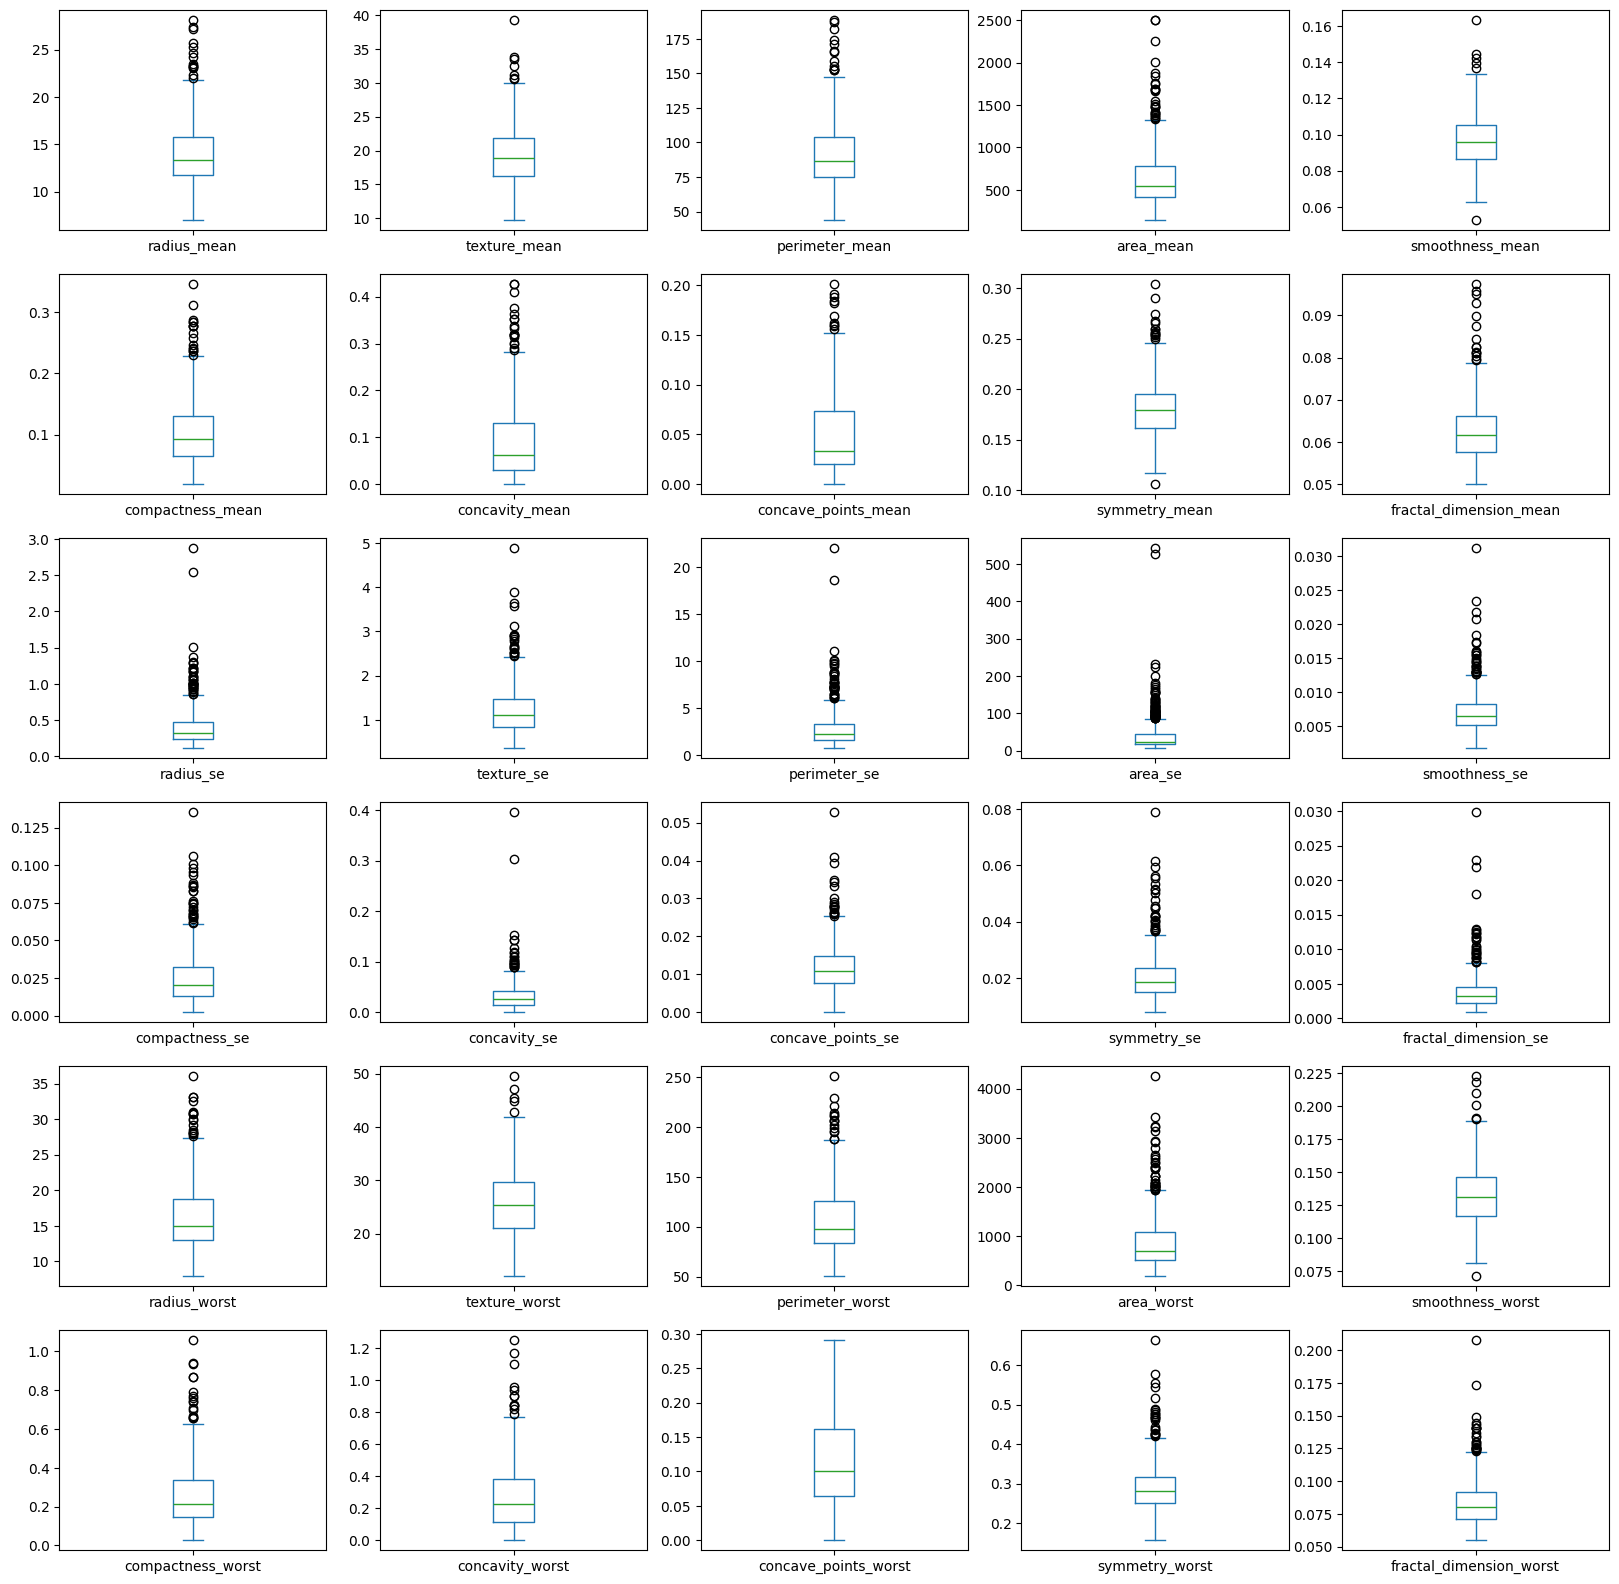

In [ ]:
# box and whisker plots - Matplotlib
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
(df.rename(columns=lambda x: str(x))
        .plot(ax=ax, kind= 'box', subplots=True, layout=(6,5))
)
plt.show()

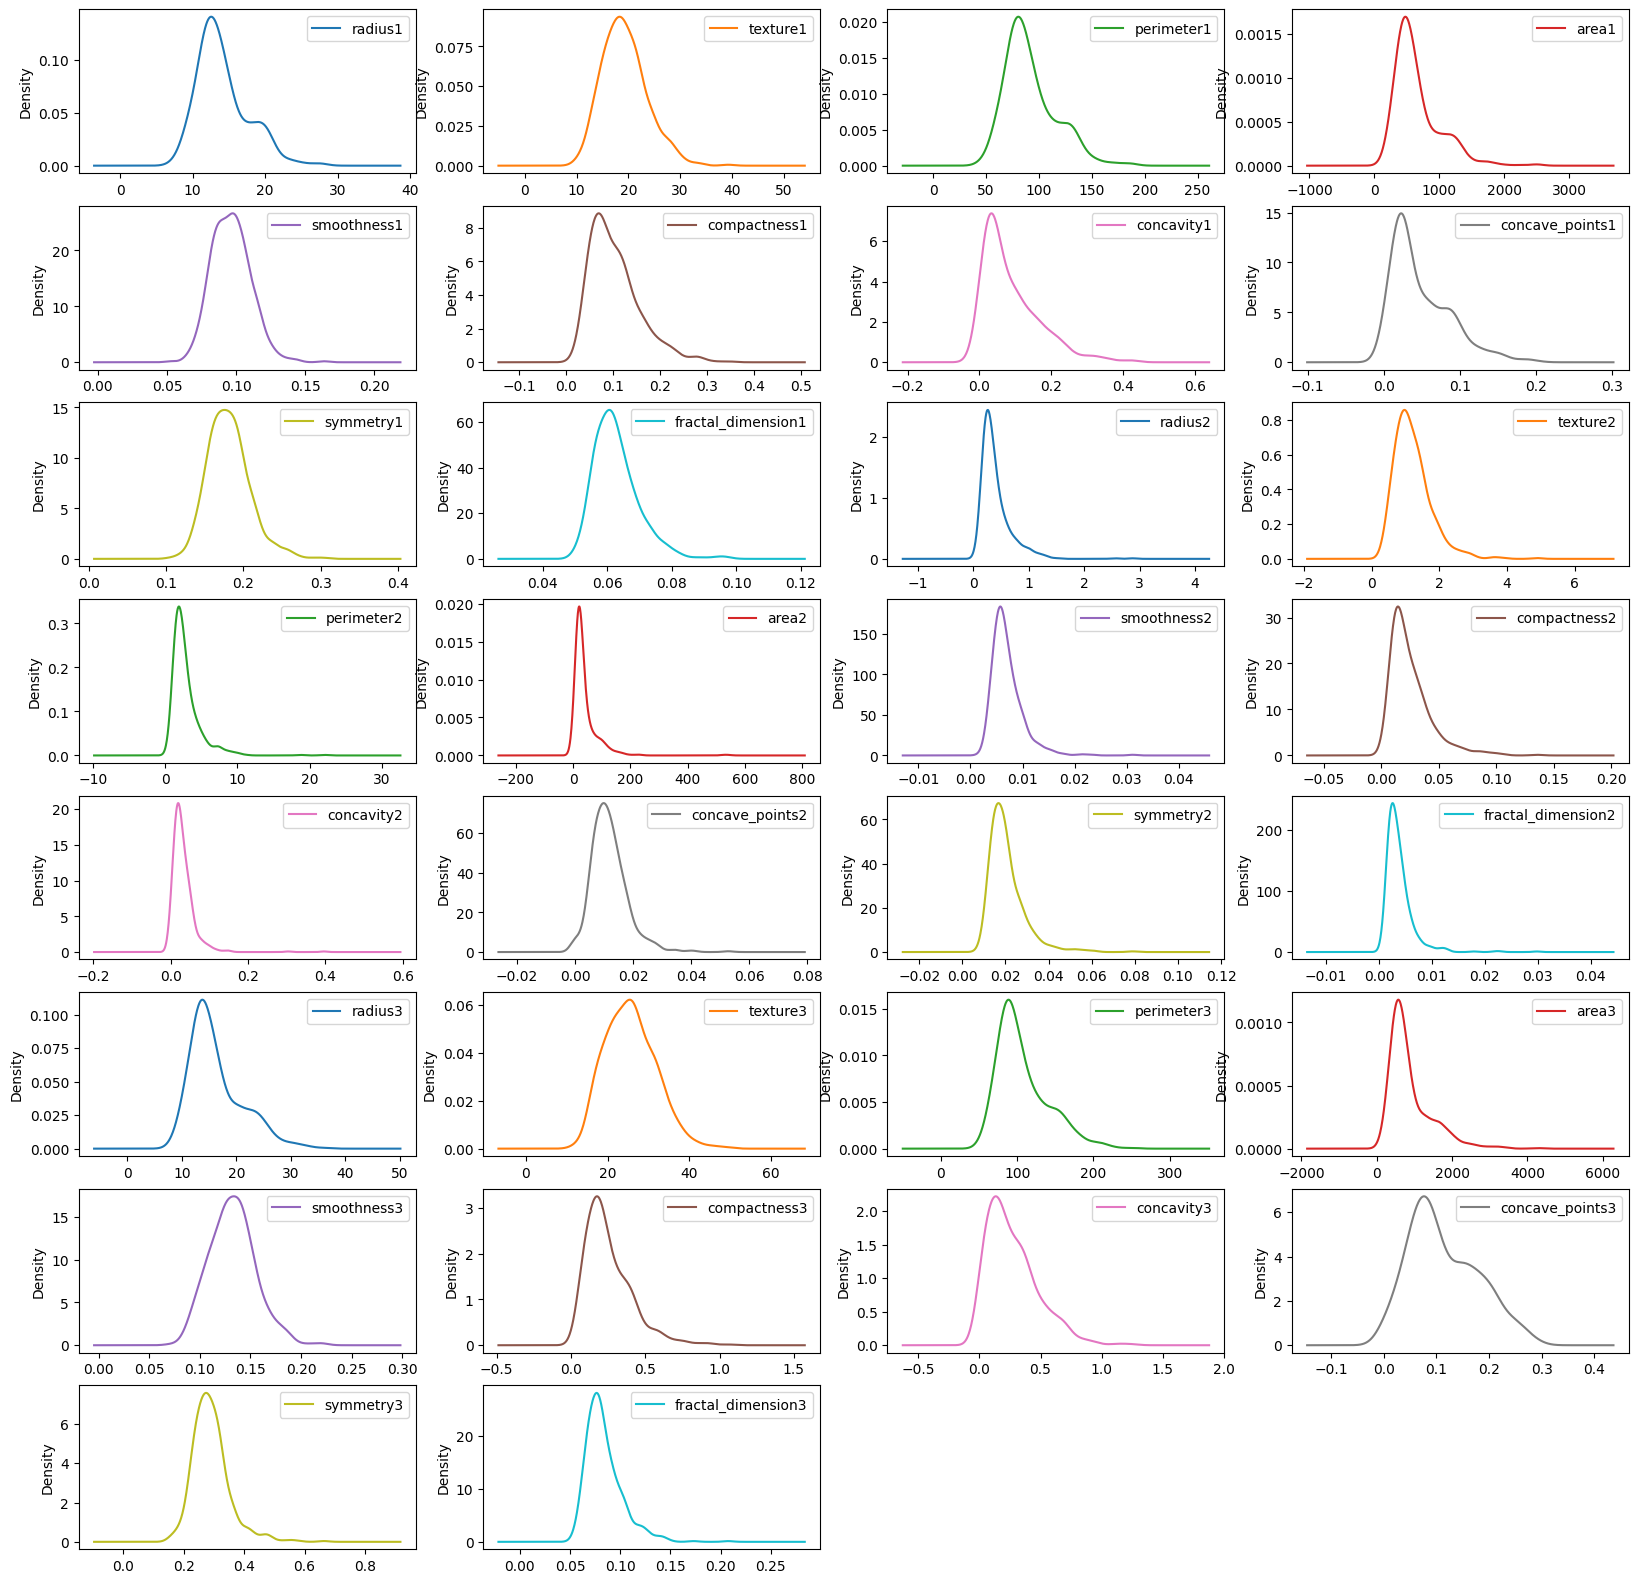

In [ ]:
# density
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
df.plot(ax=ax, kind='density', subplots=True, layout=(8,4), sharex=False, legend=True)
plt.show()

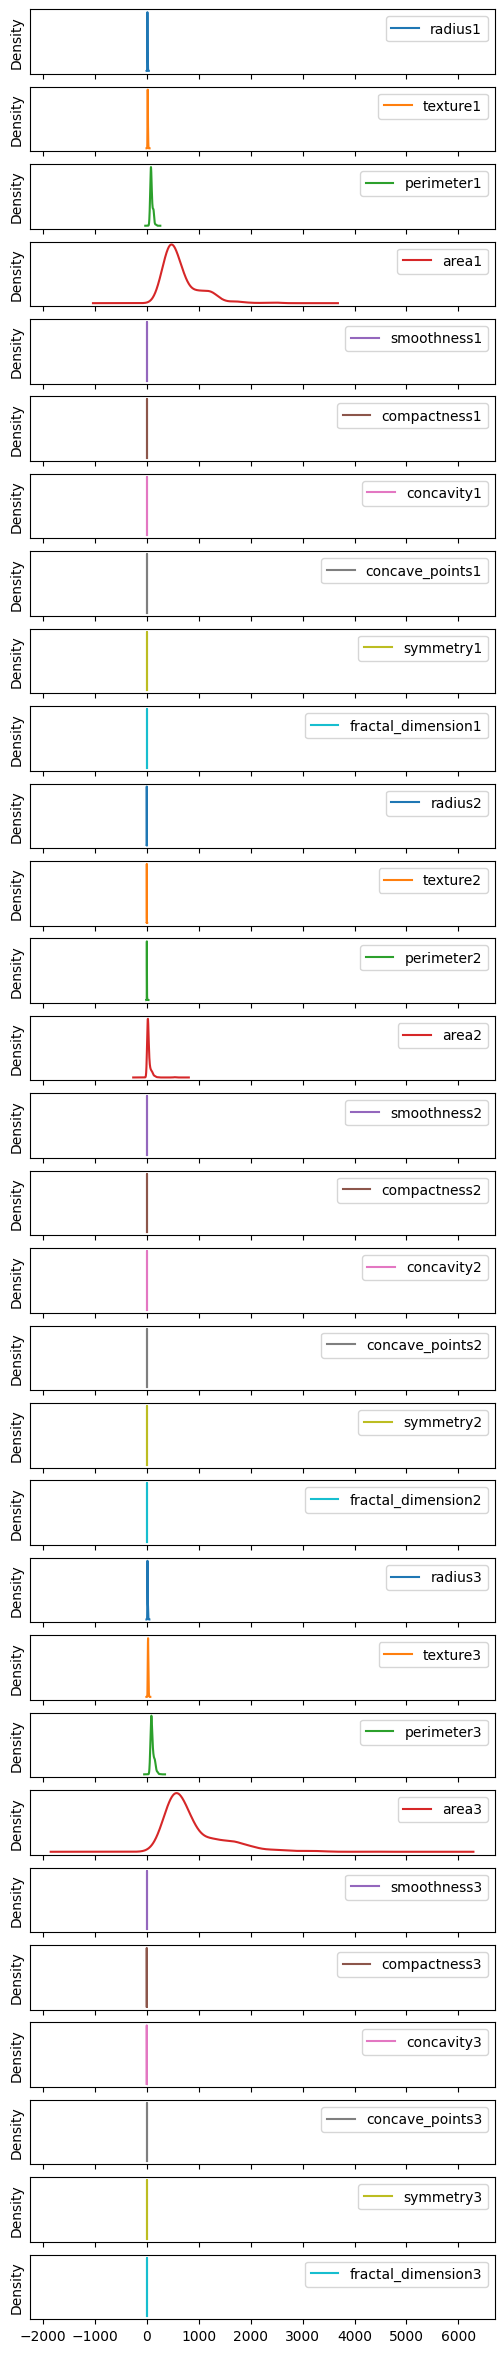

In [ ]:
df.plot.density(figsize=(6, 30), subplots=True, yticks=[])
pass